In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore")

In [4]:
train = pd.read_csv('./data/train_V2.csv')
test = pd.read_csv('./data/test_V2.csv')

In [ ]:
display(train.head())

In [ ]:
train[train['winPlacePerc'].isnull()]

In [5]:
train.drop(2744604, inplace=True)

# Feature Engineering¶

In [6]:
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')

In [7]:
train['killsNorm'] = train['kills']*((100-train['playersJoined'])/100 + 1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 + 1)
train['maxPlaceNorm'] = train['maxPlace']*((100-train['playersJoined'])/100 + 1)
train['matchDurationNorm'] = train['matchDuration']*((100-train['playersJoined'])/100 + 1)

In [8]:
train['healsandboosts'] = train['heals'] + train['boosts']

In [9]:
train['totalDistance'] = train['rideDistance'] + train['walkDistance'] + train['swimDistance']

In [10]:
train.drop(train[(train['kills'] > 0) & (train['totalDistance'] == 0)].index, inplace=True)
train.drop(train[train['longestKill'] >= 1000].index, inplace=True)
train.drop(train[train['kills'] > 30].index, inplace=True)

In [ ]:
print('There are {} different Match types in the dataset.'.format(train['matchType'].nunique()))

In [11]:
# One hot encode matchType
train = pd.get_dummies(train, columns=['matchType'])

# Take a look at the encoding
matchType_encoding = train.filter(regex='matchType')
matchType_encoding.head()

,matchType_crashfpp,matchType_crashtpp,matchType_duo,matchType_duo-fpp,matchType_flarefpp,matchType_flaretpp,matchType_normal-duo,matchType_normal-duo-fpp,matchType_normal-solo,matchType_normal-solo-fpp,matchType_normal-squad,matchType_normal-squad-fpp,matchType_solo,matchType_solo-fpp,matchType_squad,matchType_squad-fpp
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [12]:
# Turn groupId and match Id into categorical types
train['groupId'] = train['groupId'].astype('category')
train['matchId'] = train['matchId'].astype('category')

# Get category coding for groupId and matchID
train['groupId_cat'] = train['groupId'].cat.codes
train['matchId_cat'] = train['matchId'].cat.codes

# Get rid of old columns
train.drop(columns=['groupId', 'matchId'], inplace=True)

# Lets take a look at our newly created features
train[['groupId_cat', 'matchId_cat']].head()

,groupId_cat,matchId_cat
0,613675,30085
1,827693,32751
2,843386,3143
3,1340248,45260
4,1757581,20531


In [13]:
train.drop(columns = ['Id'], inplace=True)

In [14]:
train.to_csv("./data/train.csv", index=False)

In [ ]:
train.shape

# Preparation for Machine Learning

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz
import scipy
from scipy.cluster import hierarchy as hc

## Sampling

In [16]:
sample = 500000
df_sample = train.sample(sample)

## Split target variable, validation data, etc.

In [17]:
df = df_sample.drop(columns = ['winPlacePerc']) #all columns except target
y = df_sample['winPlacePerc'] # Only target variable

In [18]:
# Function for splitting training and validation data
def split_vals(a, n : int): 
    return a[:n].copy(), a[n:].copy()
val_perc = 0.12 # % to use for validation set
n_valid = int(val_perc * sample) 
n_trn = len(df)-n_valid
# Split data
raw_train, raw_valid = split_vals(df_sample, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

# Check dimensions of samples
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (440000, 49) Sample target shape:  (440000,) Sample validation shape:  (60000, 49)


## Set metrics (MAE)

In [19]:
# Metric used for the PUBG competition (Mean Absolute Error (MAE))
from sklearn.metrics import mean_absolute_error

# Function to print the MAE (Mean Absolute Error) score
# This is the metric used by Kaggle in this competition
def print_score(m : RandomForestRegressor):
    res = ['mae train: ', mean_absolute_error(m.predict(X_train), y_train), 
           'mae val: ', mean_absolute_error(m.predict(X_valid), y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

## First basic Random Forest Model

In [20]:
# Train basic model
m1 = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m1.fit(X_train, y_train)
print_score(m1)

['mae train: ', 0.038934469285904744, 'mae val: ', 0.06241928502243615]


## Feature Importance

In [21]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [22]:
fi = rf_feat_importance(m1, df); fi[:10]

,cols,imp
21,walkDistance,0.228610
30,totalDistance,0.189637
6,killPlace,0.154292
1,boosts,0.076417
5,heals,0.056891
29,healsandboosts,0.054947
22,weaponsAcquired,0.048226
16,rideDistance,0.029524
10,longestKill,0.016571
25,killsNorm,0.015104


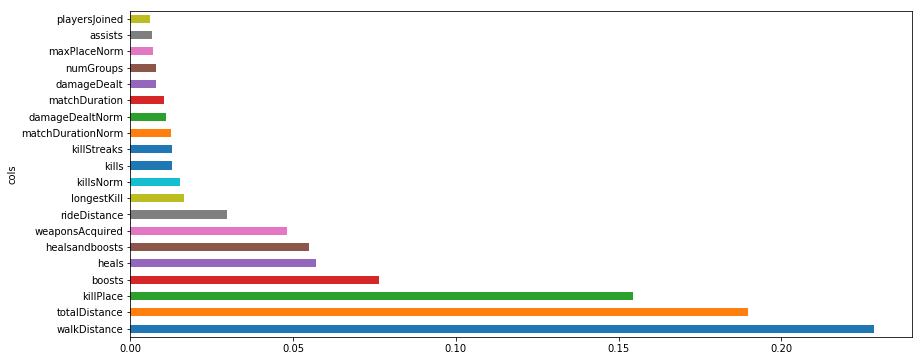

In [23]:
plot1 = fi[:20].plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot1

In [24]:
to_keep = fi[fi.imp>0.005].cols
print('Significant features: ', len(to_keep))
to_keep

Significant features:  21


21         walkDistance
30        totalDistance
6             killPlace
1                boosts
5                 heals
29       healsandboosts
22      weaponsAcquired
16         rideDistance
10          longestKill
25            killsNorm
8                 kills
9           killStreaks
28    matchDurationNorm
26      damageDealtNorm
11        matchDuration
2           damageDealt
13            numGroups
27         maxPlaceNorm
0               assists
24        playersJoined
12             maxPlace
Name: cols, dtype: object

In [25]:
df_keep = df[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [26]:
# Train model on top features
m2 = RandomForestRegressor(n_estimators=80, min_samples_leaf=3, max_features='sqrt',
                          n_jobs=-1)
m2.fit(X_train, y_train)
print_score(m2)

['mae train: ', 0.03746934591124878, 'mae val: ', 0.06011224766820998]


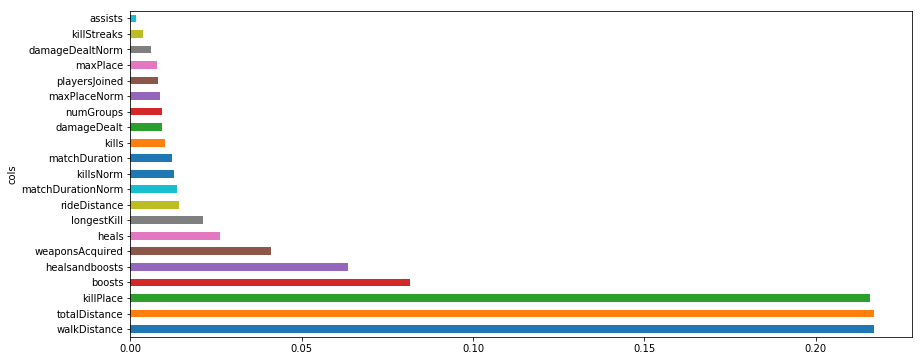

In [27]:
fi_to_keep = rf_feat_importance(m2, df_keep)
plot2 = fi_to_keep.plot('cols', 'imp', figsize=(14,6), legend=False, kind = 'barh')
plot2

## Final Random Forest Model

In [28]:
# Prepare data
val_perc_full = 0.12 # % to use for validation set
n_valid_full = int(val_perc_full * len(train)) 
n_trn_full = len(train)-n_valid_full
df_full = train.drop(columns = ['winPlacePerc']) # all columns except target
y = train['winPlacePerc'] # target variable
df_full = df_full[to_keep] # Keep only relevant features
X_train, X_valid = split_vals(df_full, n_trn_full)
y_train, y_valid = split_vals(y, n_trn_full)

# Check dimensions of data
print('Sample train shape: ', X_train.shape, 
      'Sample target shape: ', y_train.shape, 
      'Sample validation shape: ', X_valid.shape)

Sample train shape:  (3911878, 21) Sample target shape:  (3911878,) Sample validation shape:  (533437, 21)


In [29]:
to_keep

21         walkDistance
30        totalDistance
6             killPlace
1                boosts
5                 heals
29       healsandboosts
22      weaponsAcquired
16         rideDistance
10          longestKill
25            killsNorm
8                 kills
9           killStreaks
28    matchDurationNorm
26      damageDealtNorm
11        matchDuration
2           damageDealt
13            numGroups
27         maxPlaceNorm
0               assists
24        playersJoined
12             maxPlace
Name: cols, dtype: object

In [ ]:
m3 = RandomForestRegressor(n_estimators=70, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1)
m3.fit(X_train, y_train)
print_score(m3)